In [17]:
import  logging

def configure_logger():
    root_logger = logging.getLogger()
    root_logger.setLevel(logging.INFO)
    handler = logging.StreamHandler()
    formatter = logging.Formatter(
        fmt='%(asctime)s - %(name)s - %(levelname)s - %(message)s')
    handler.setFormatter(formatter)
    root_logger.addHandler(handler)

In [18]:
import os 

import numpy as np
import pandas as pd

In [19]:
# !mkdir ../../mary-data

In [20]:
# !gsutil -m rsync -r gs://elvos/processed/luke1/ ../../mary-data

In [21]:
# !ls ../../mary-data

In [22]:
LENGTH, WIDTH, HEIGHT = (160, 160, 50)

VALID_TRAINING_INDICES = []
VALID_VALIDATION_INDICES = []

def load_training_data() -> np.array:
    """Returns 4D matri x of training data
    Data is in the form (n_samples, 1, w, h). 
    Samples are sorted by patient ID"""
    arrays = []
    training_filenames = sorted(os.listdir(
        '/home/mdong/mary-data/training/'))
    for i, filename in enumerate(training_filenames):
        arr = np.load('/home/mdong/mary-data/training/' + filename)
        if arr.shape == (LENGTH, WIDTH, HEIGHT):
            arrays.append(arr)
            VALID_TRAINING_INDICES.append(i)
        else:
            logging.info(
                f'training file {filename} has incorrect shape {arr.shape}')
    return np.stack(arrays)

def load_validation_data() -> np.array:
    """Returns 4D matri x of validation data
    Data is in the form (n_samples, 1, w, h). 
    Samples are sorted by patient ID"""
    
    arrays = []
    validation_filenames = sorted(os.listdir(
        '/home/mdong5/mary-data/validation/'))
    for i, filename in enumerate(validation_filenames):
        arr = np.load('/home/mdong/mary-data/validation/' + filename)
        if arr.shape == (LENGTH, WIDTH, HEIGHT):
            arrays.append(arr)
            VALID_VALIDATION_INDICES.append(i)
        else:
            logging.info(
                f'training file {filename} has incorrect shape {arr.shape}')
    return np.stack(arrays)

def load_labels() -> (np.array, np.array):
    training_df = pd.read_csv('/home/mdong/mary-data/training_labels.csv')
    validation_df = pd.read_csv('/home/mdong/mary-data/validation_labels.csv')
    training_labels = training_df.sort_values('patient_id')['label'].values
    validation_labels = validation_df.sort_values('patient_id')['label'].values
    return training_labels, validation_labels

In [ ]:
VALID_TRAINING_INDICES = []
VALID_VALIDATION_INDICES = []

X_train = load_training_data()
X_valid = load_validation_data()
y_train, y_valid = load_labels()
y_train = y_train[VALID_TRAINING_INDICES]
y_valid = y_valid[VALID_VALIDATION_INDICES]

print(X_train.shape, y_train.shape, X_valid.shape, y_valid.shape)

In [18]:
def squash_height(X: np.array):
    return X.max(axis=3)

In [19]:
X_train_squashed = squash_height(X_train)
X_train = np.stack([X_train_squashed, X_train_squashed, X_train_squashed], axis=3)
print(X_train.shape)
X_valid_squashed = squash_height(X_valid)
X_valid = np.stack([X_valid_squashed, X_valid_squashed, X_valid_squashed], axis=3)
print(X_valid.shape)

(500, 160, 160, 3)
(378, 160, 160, 3)


In [20]:
## Exploration

In [21]:
%matplotlib inline

In [22]:
print(X_train.shape, X_train.min(), X_train.max())

(500, 160, 160, 3) 0.0 1.0


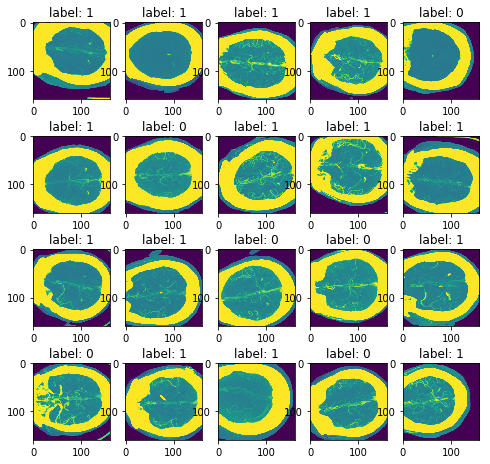

In [25]:
import matplotlib.pyplot as plt

ROWS = 4
COLS = 5
OFFSET = 40
fig = plt.figure(figsize=(8, 8))
for i in range(20):
    ax = fig.add_subplot(ROWS, COLS, i + 1)
    ax.set_title(f'label: {y_train[i]}')
    plt.imshow(X_train_squashed[i + OFFSET])

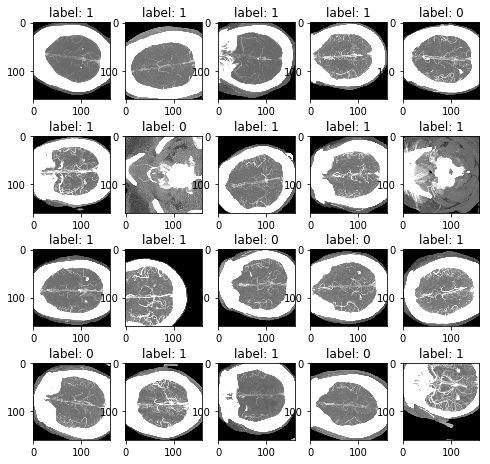

In [26]:
ROWS = 4
COLS = 5
OFFSET = 60
fig = plt.figure(figsize=(8, 8))
for i in range(20):
    ax = fig.add_subplot(ROWS, COLS, i + 1)
    ax.set_title(f'label: {y_train[i]}')
    plt.imshow(X_train[i + OFFSET])

In [27]:
from keras import applications
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
from keras.models import Sequential
from keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D 
from keras.models import Model
from keras.optimizers import Adam

# expected input shape: (160, 160, 3)
base_model = applications.nasnet.NASNetMobile(input_shape=(160, 160, 3), include_top=False, weights='imagenet', input_tensor=None, pooling=None, classes=1000)

Using TensorFlow backend.
/gpfs/main/home/mdong5/elvo-analysis/venv/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


19996672/19993432 [==============================] - 1s 0us/step


In [28]:
print(y_train)

[1 1 1 1 0 1 0 1 1 1 1 1 0 0 1 0 1 1 0 1 1 1 1 1 0 1 1 1 1 1 1 0 0 1 1 1 1
 0 0 1 1 1 1 1 1 0 1 0 1 1 1 1 0 1 0 1 0 0 1 1 1 1 1 1 0 0 1 1 1 0 1 1 0 1
 0 1 0 0 0 0 1 1 1 0 1 1 0 1 1 1 1 0 0 0 0 0 1 1 1 1 1 0 1 1 1 1 0 0 0 1 1
 1 0 1 0 1 0 1 1 1 0 0 0 1 0 0 1 0 0 1 0 1 1 1 0 0 0 0 1 1 0 1 1 0 1 1 0 0
 1 0 1 1 0 0 1 0 1 1 1 0 0 0 0 0 1 1 1 0 1 1 1 0 1 1 1 1 1 0 1 1 0 1 0 1 1
 0 1 0 1 1 0 1 1 1 0 0 0 1 0 1 0 1 1 0 0 1 1 0 0 1 1 1 0 1 1 1 1 1 1 0 0 0
 0 0 1 0 0 1 1 1 0 0 1 1 0 1 1 1 0 0 1 1 0 1 0 1 1 1 1 1 1 1 1 0 1 0 1 0 0
 0 0 0 1 1 1 1 0 0 1 1 1 1 0 0 1 1 0 1 1 1 1 1 0 1 0 1 1 1 1 0 0 0 0 1 1 1
 0 1 1 1 1 0 0 1 0 0 0 0 0 0 1 0 0 1 0 0 1 0 1 0 0 0 0 0 1 1 1 1 1 1 0 1 1
 1 1 0 0 1 0 1 1 0 1 1 0 1 0 1 1 1 0 1 0 1 1 1 0 1 1 0 1 1 1 1 1 1 0 1 0 1
 0 1 0 0 1 1 1 0 1 0 0 1 0 1 1 0 1 1 1 1 0 1 1 0 0 1 0 0 1 1 1 1 0 1 1 1 1
 0 1 1 0 1 0 0 0 1 1 1 1 1 1 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 1 1 1 0 0 0 0 0
 1 1 0 1 0 1 1 1 0 1 1 0 0 0 0 0 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 0 1 0 0
 1 1 0 0 0 1 0 0 0 0 0 1 

In [29]:
# build a classifier model to put on top of the convolutional model
# This consists of a global average pooling layer and a fully connected layer with 256 nodes # Then apply dropout and sigmoid activation
model_top = Sequential()
model_top.add(GlobalAveragePooling2D(input_shape=base_model.output_shape[1:], data_format=None))
model_top.add(Dense(256, activation='relu'))
model_top.add(Dropout(0.5))
model_top.add(Dense(1, activation='sigmoid'))
model = Model(inputs=base_model.input, outputs=model_top(base_model.output))
# Compile model using Adam optimizer with common values and binary cross entropy loss # Use low learning rate (lr) for transfer learning
model.compile(optimizer=Adam(lr=0.00001, beta_1=0.9, beta_2=0.999, epsilon=1e-08,decay=0.0), loss='binary_crossentropy', metrics=['accuracy'])

In [30]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 160, 160, 3)  0                                            
__________________________________________________________________________________________________
stem_conv1 (Conv2D)             (None, 79, 79, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
stem_bn1 (BatchNormalization)   (None, 79, 79, 32)   128         stem_conv1[0][0]                 
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 79, 79, 32)   0           stem_bn1[0][0]                   
__________________________________________________________________________________________________
reduction_

Total params: 4,540,565
Trainable params: 4,503,827
Non-trainable params: 36,738
__________________________________________________________________________________________________


In [31]:
# epochs = number of passes of through training data # batch_size = number images processed at same time train_samples = 65

epochs = 10
batch_size = 32

In [32]:
# Fine-tune the pretrained Inception V3 model using the data generator 
# Specify steps per epoch (number of samples/batch_size)
history = model.fit(X_train, y_train,
                    epochs=epochs,
                    batch_size=batch_size,
                    validation_data=(X_valid, y_valid))

Train on 500 samples, validate on 378 samples
Epoch 1/10
500/500 [==============================] - 37s 74ms/step - loss: 0.7775 - acc: 0.5080 - val_loss: 0.6955 - val_acc: 0.5212
Epoch 2/10
500/500 [==============================] - 9s 18ms/step - loss: 0.7419 - acc: 0.5080 - val_loss: 0.6790 - val_acc: 0.5608
Epoch 3/10
500/500 [==============================] - 9s 18ms/step - loss: 0.7169 - acc: 0.5440 - val_loss: 0.6714 - val_acc: 0.5688
Epoch 4/10
500/500 [==============================] - 9s 18ms/step - loss: 0.7058 - acc: 0.5720 - val_loss: 0.6692 - val_acc: 0.5688
Epoch 5/10
500/500 [==============================] - 9s 18ms/step - loss: 0.6864 - acc: 0.5680 - val_loss: 0.6689 - val_acc: 0.5767
Epoch 6/10
500/500 [==============================] - 9s 18ms/step - loss: 0.6597 - acc: 0.6120 - val_loss: 0.6695 - val_acc: 0.5873
Epoch 7/10
500/500 [==============================] - 9s 18ms/step - loss: 0.6490 - acc: 0.6200 - val_loss: 0.6638 - val_acc: 0.5635
Epoch 8/10
500/500 [==

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


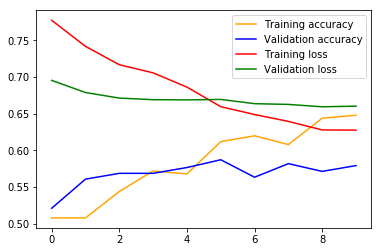

In [33]:
# import matplotlib library, and plot training cuve
import matplotlib.pyplot as plt 
print(history.history.keys())
plt.figure()
plt.plot(history.history['acc'], 'orange', label='Training accuracy') 
plt.plot(history.history['val_acc'], 'blue', label='Validation accuracy') 
plt.plot(history.history['loss'], 'red', label='Training loss') 
plt.plot(history.history['val_loss'], 'green', label='Validation loss') 
plt.legend()
plt.show()

In [34]:
model.save('model-inception-06-12-18')